## Small model to predict compute time from parameters of dense/convolutional layer

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.externals import joblib
import shutil

C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
# Root directory of the project
ROOT_DIR = os.path.abspath("../../")
sys.path.append(ROOT_DIR)  # To find local version of the library

In [32]:
#from prediction_model_tf2.model import Model
from prediction_model_tf2.model_windows import Model
from prediction_model_tf2 import dataprep

### Import data as pd dataframe
#### Data should contain parameters and max/median/min/std of time

In [17]:
model_name = 'all'

MODEL_PATH = os.path.join(ROOT_DIR, 'prediction_model_tf2', 'models', '%s' %model_name)
DATA_PATH = os.path.join(ROOT_DIR, 'prediction_model_tf2', 'practicum_data')

In [6]:
try:
    MODEL_PATH
except:
    pass 

useData = 'Conv' # 'Dense' or 'Conv'
#useData = 'Dense'

In [20]:
if useData == 'Conv':
    df = pd.read_pickle(os.path.join(DATA_PATH,'Data_convolution_%s.pkl' %model_name))
    scaler_filename = os.path.join(MODEL_PATH,'scaler_Conv.save')
elif useData == 'Dense':
    df = pd.read_pickle(os.path.join(DATA_PATH,'Data_dense_%s.pkl' %model_name))
    scaler_filename = os.path.join(MODEL_PATH,'scaler_Dense.save')
else:
    print('useData must be Dense or Conv, currently is %s' %useData)

In [75]:
df

,batchsize,matsize,kernelsize,channels_in,channels_out,strides,padding,precision,use_bias,gpu,...,opt_SGD,act_None,act_relu,act_sigmoid,act_tanh,peak_performance,IO,bandwidth,cores,clock
0,48,342,1,17,8,1,1,32,1,0,...,0,0,0,1,0,14900,15.9,732,3584,1329
1,44,224,2,25,27,2,0,32,0,0,...,0,0,0,0,1,14900,15.9,732,3584,1329
2,31,102,3,81,66,2,1,32,0,0,...,0,0,1,0,0,14900,15.9,732,3584,1329
3,19,98,7,15,101,3,1,32,1,0,...,0,0,0,1,0,14900,15.9,732,3584,1329
4,20,387,2,8,6,4,1,32,0,0,...,0,0,0,1,0,14900,15.9,732,3584,1329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,25,62,1,145,146,1,0,32,0,0,...,0,0,0,0,1,5591,12.0,240,2496,824
2496,32,453,5,17,14,1,1,32,1,0,...,0,0,1,0,0,5591,12.0,240,2496,824
2497,17,21,6,267,256,2,0,32,0,0,...,0,0,1,0,0,5591,12.0,240,2496,824
2498,28,344,1,2,14,2,1,32,1,0,...,0,0,0,0,1,5591,12.0,240,2496,824


#### Researcher's Results

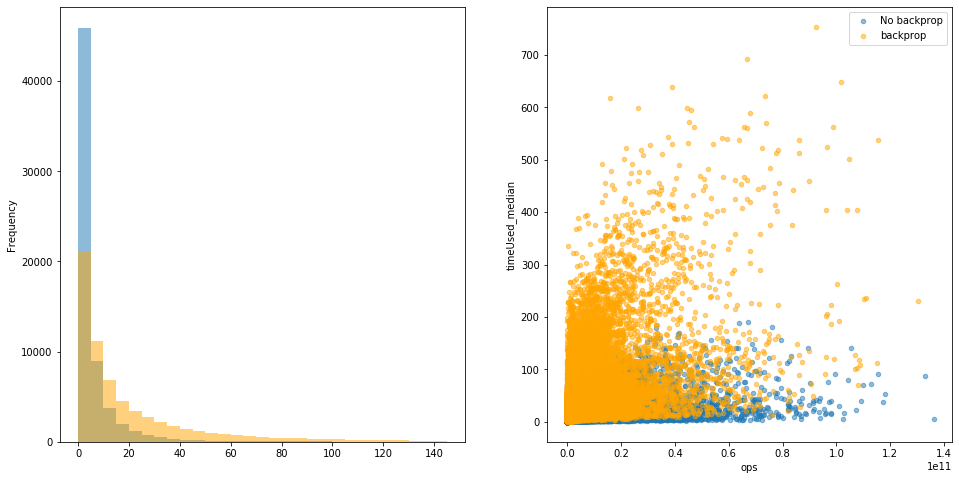

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[16,8])

df[df['opt_None']==1]['timeUsed_median'].plot.hist(bins=np.arange(0,150,5), ax=axes[0], alpha=.5)
df[df['opt_None']==0]['timeUsed_median'].plot.hist(bins=np.arange(0,150,5), ax=axes[0], alpha=.5, color='orange')

df[df['opt_None']==1].plot.scatter(x='ops', y='timeUsed_median', ax=axes[1], alpha=.5, label='No backprop')
df[df['opt_None']==0].plot.scatter(x='ops', y='timeUsed_median', ax=axes[1], alpha=.5, color='orange', label='backprop')

plt.show()

#### Our Results

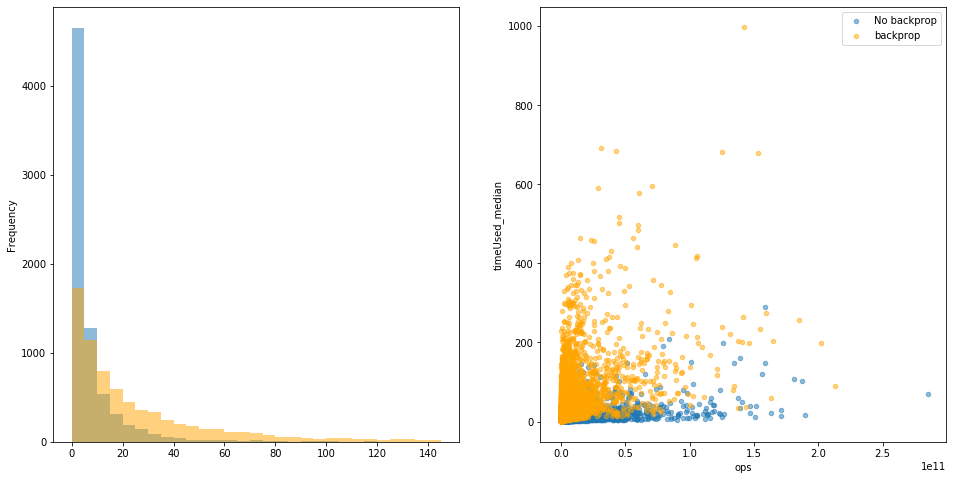

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[16,8])

df[df['opt_None']==1]['timeUsed_median'].plot.hist(bins=np.arange(0,150,5), ax=axes[0], alpha=.5)
df[df['opt_None']==0]['timeUsed_median'].plot.hist(bins=np.arange(0,150,5), ax=axes[0], alpha=.5, color='orange')

df[df['opt_None']==1].plot.scatter(x='ops', y='timeUsed_median', ax=axes[1], alpha=.5, label='No backprop')
df[df['opt_None']==0].plot.scatter(x='ops', y='timeUsed_median', ax=axes[1], alpha=.5, color='orange', label='backprop')

plt.show()

In [8]:
if useData == 'Dense':
    model_name = '%s_dense' %model_name

In [9]:
# # Only forward pass
# df = df[df['opt_SGD']==1]
# model_name = '%s_SGD'%model_name
# scaler_filename = ("scaler_%s_Conv.save" %model_name)

### Generate train, test and validation datasets (80%,10%,10%)
#### Normalise data, generate train, test, validation dataset
#### Use median of time as target parameter

In [79]:
split=[.8,.1,.1]
if model_name == 'all' or model_name[0:3] == 'no_':
    data_cols_conv = ['batchsize','elements_matrix','elements_kernel',
                      'channels_in','channels_out','padding','strides','use_bias', 
                      'opt_SGD','opt_Adadelta','opt_Adagrad','opt_Momentum','opt_Adam','opt_RMSProp',
                      'act_relu','act_tanh','act_sigmoid',
                      'bandwidth','cores','clock']
    
    data_cols_dense = ['batchsize','dim_input','dim_output',
                       'opt_SGD','opt_Adadelta','opt_Adagrad','opt_Momentum','opt_Adam','opt_RMSProp',
                       'act_relu','act_tanh','act_sigmoid',
                      'bandwidth','cores','clock']
    
else:
    data_cols_conv = ['batchsize','elements_matrix','elements_kernel',
                      'channels_in','channels_out','padding','strides','use_bias', 
                      'opt_SGD','opt_Adadelta','opt_Adagrad','opt_Momentum','opt_Adam','opt_RMSProp',
                      'act_relu','act_tanh','act_sigmoid']
    
    data_cols_dense = ['batchsize','dim_input','dim_output',
                       'opt_SGD','opt_Adadelta','opt_Adagrad','opt_Momentum','opt_Adam','opt_RMSProp',
                       'act_relu','act_tanh','act_sigmoid']


if useData == 'Conv':
    data_cols = data_cols_conv
elif useData == 'Dense':
    data_cols = data_cols_dense

In [80]:
data, time, train, test, validation, scaler = dataprep.data_preprocess(df,data_cols,split)
joblib.dump(scaler, scaler_filename) 

Size of train dataset: 11993 
Size of test dataset: 1499 
Size of validation dataset: 1500


['C:\\Users\\ASUS\\Documents\\GitHub\\ml-performance-prediction\\prediction_model_tf2\\models\\all\\scaler_Conv.save']

### Define model

In [81]:
if model_name == 'all' or model_name[0:3] == 'no_':
    num_neurons = [32,64,128,128,128,128]
else:
    num_neurons = [32,64,128,128]
    
lr_initial = 0.1
lr_decay_step = 40

In [82]:
tf.compat.v1.disable_eager_execution() #have to disable eager execution after TF2 migration

tf.compat.v1.reset_default_graph()
data_dim = data['Train'].shape[1]

inputs = tf.compat.v1.placeholder(tf.float32, shape=(None, data_dim), name='model_input')
targets = tf.compat.v1.placeholder(tf.float32, shape=(None), name='model_targets')
learning_rate = tf.compat.v1.placeholder(tf.float32, shape=[])
reg_constant = .00001
dropout_rate = 0.2
batch_size = 128

#### Remove checkpoints and tb output

In [83]:
try:
    folder = './checkpoints/%s' % model_name
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        os.remove(file_path)

    folder = './graphs/prediction/test/%s' % model_name
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file) 
        os.remove(file_path)

    folder = './graphs/prediction/train/%s' % model_name
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file) 
        os.remove(file_path)
        
    print('Checkpoints cleared')
except:
    print('Nothing to delete')
    

Checkpoints cleared


In [84]:
model = Model(inputs,targets,learning_rate,reg_constant,dropout_rate,
              num_neurons,lr_initial,lr_decay_step,batch_size,model_name)

In [85]:
model.prediction
model.train_op

<tf.Operation 'Adam' type=AssignAddVariableOp>

### Run model, generate plots
##### Checkpoints in ./Checkpoint, tb graphs and summaries in ./graphs

In [86]:
model.train(data['Train'],time['Train'],data['Test'],time['Test'],300)

C:\Users\ASUS\Documents\GitHub\ml-performance-prediction\prediction_model_tf2\notebooks
Epoch 0: Train loss 0.915, Test loss 0.419
Epoch 10: Train loss 0.229, Test loss 0.224
Epoch 20: Train loss 0.133, Test loss 0.115
Epoch 30: Train loss 0.110, Test loss 0.106
Epoch 40: Train loss 0.063, Test loss 0.074
Epoch 50: Train loss 0.055, Test loss 0.070
Epoch 60: Train loss 0.049, Test loss 0.078
Epoch 70: Train loss 0.048, Test loss 0.073
Epoch 80: Train loss 0.035, Test loss 0.064
Epoch 90: Train loss 0.032, Test loss 0.060
Epoch 100: Train loss 0.030, Test loss 0.060
Epoch 110: Train loss 0.030, Test loss 0.063
Epoch 120: Train loss 0.025, Test loss 0.061
Epoch 130: Train loss 0.025, Test loss 0.060
Epoch 140: Train loss 0.023, Test loss 0.061
Epoch 150: Train loss 0.023, Test loss 0.061
Epoch 160: Train loss 0.021, Test loss 0.060
Epoch 170: Train loss 0.021, Test loss 0.061
Epoch 180: Train loss 0.021, Test loss 0.060
Epoch 190: Train loss 0.021, Test loss 0.060
Epoch 200: Train loss 0

In [87]:
saver = tf.compat.v1.train.Saver()
folder = os.path.join(ROOT_DIR, 'prediction_model_tf2/models/%s/saved_model' %model_name)
try:
    shutil.rmtree(folder)
except:
    pass
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    
    ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/%s/checkpoint' %model_name))
    saver.restore(sess, ckpt.model_checkpoint_path)
    tf.compat.v1.saved_model.simple_save(
            sess,
            folder,
            inputs={'model_input': inputs,'model_istraining': model.istraining},
            outputs={'model_prediction': model.prediction})

INFO:tensorflow:Restoring parameters from checkpoints/all\prediction-299
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: C:\Users\ASUS\Documents\GitHub\ml-performance-prediction\prediction_model_tf2/models/all/saved_model\saved_model.pb


INFO:tensorflow:Restoring parameters from checkpoints/all\prediction-299


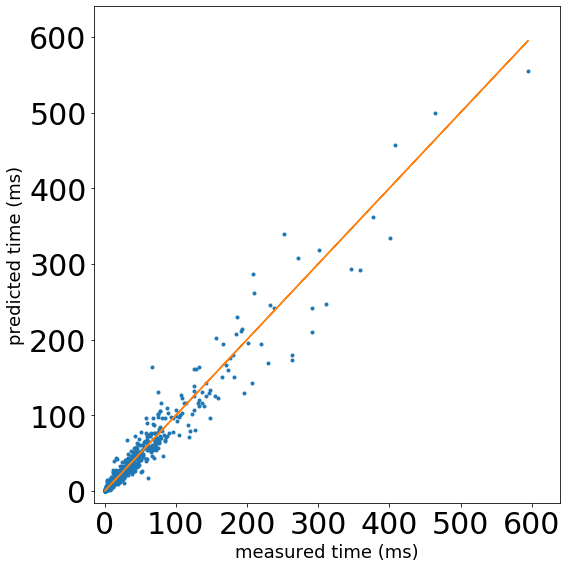

RMS test error = 10.4 ms


In [88]:
saver = tf.compat.v1.train.Saver()
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    
    ckpt = tf.compat.v1.train.get_checkpoint_state(os.path.dirname('checkpoints/%s/checkpoint' %model_name))
    saver.restore(sess, ckpt.model_checkpoint_path)
    
    v = sess.run(tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES))
    
    test_prediction, test_loss = sess.run(
            [model.prediction,model.loss], 
            feed_dict={model.inputs: data['Test'], 
                       model.targets: time['Test'],
                       model.istraining: False}) 
    
RMS_test_error = np.sqrt(np.mean((time['Test']-test_prediction)**2))

fig,ax = plt.subplots(1,1,figsize=[8,8])
ax.plot(time['Test'],test_prediction,'.')
ax.plot(time['Test'],time['Test'],2)


ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(plt.NullFormatter())
ax.yaxis.set_minor_formatter(plt.NullFormatter())

matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18) 

plt.xlabel('measured time (ms)',fontsize=18)
plt.ylabel('predicted time (ms)',fontsize=18)


axlim = max(plt.xlim()[1],plt.ylim()[1])


#plt.axis('equal')
ax.set_xlim(-axlim*.025,axlim*1.025)
ax.set_ylim(-axlim*.025,axlim*1.025)

plt.tight_layout()

# if useData == 'Conv':
#     plt.savefig('figures/Validation_%s_conv.png' %model_name, dpi=300)
# elif useData == 'Dense':
#     plt.savefig('figures/Validation_%s_fc.png' %model_name, dpi=300)

plt.show()
print('RMS test error = %.3g ms' %(RMS_test_error))

### STOP here - validation data set

INFO:tensorflow:Restoring parameters from checkpoints/all\prediction-299


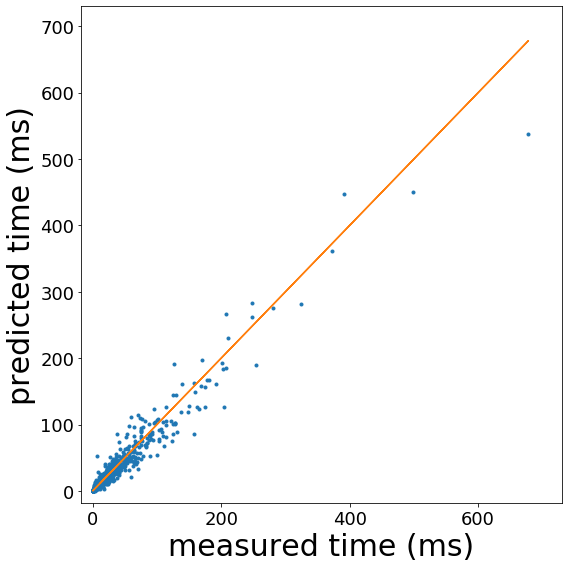

RMS validation error = 9.45 ms
Percentage error = 23.3%


In [89]:
saver = tf.compat.v1.train.Saver()
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    
    ckpt = tf.compat.v1.train.get_checkpoint_state(os.path.dirname('checkpoints/%s/checkpoint' %model_name))
    saver.restore(sess, ckpt.model_checkpoint_path)
    
    v = sess.run(tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES))
    
    validation_prediction, validation_loss = sess.run(
            [model.prediction,model.loss], 
            feed_dict={model.inputs: data['Validation'], 
                       model.targets: time['Validation'],
                       model.istraining: False}) 
    
RMS_validation_error=np.sqrt(np.mean((time['Validation']-validation_prediction)**2))
perc_error = np.mean(np.abs(time['Validation']-validation_prediction)/time['Validation'])*100

fig,ax = plt.subplots(1,1,figsize=[8,8])
ax.plot(time['Validation'],validation_prediction,'.')
ax.plot(time['Validation'],time['Validation'],2)


ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(plt.NullFormatter())
ax.yaxis.set_minor_formatter(plt.NullFormatter())

matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 

plt.xlabel('measured time (ms)',fontsize=30)
plt.ylabel('predicted time (ms)',fontsize=30)


axlim = max(plt.xlim()[1],plt.ylim()[1])


#plt.axis('equal')
ax.set_xlim(-axlim*.025,axlim*1.025)
ax.set_ylim(-axlim*.025,axlim*1.025)

# ax.xaxis.set_ticks([0,25,50,75,100,125])

plt.tight_layout()

# if useData == 'Conv':
#     plt.savefig('figures/Validation_%s_conv.png' %model_name, dpi=300)
# elif useData == 'Dense':
#     plt.savefig('figures/Validation_%s_fc.png' %model_name, dpi=300)

plt.show()
print('RMS validation error = %.3g ms' %(RMS_validation_error))
print('Percentage error = %.3g%%' %(perc_error))

## Build a linear regression as comparison

In [66]:
df_validation = df.iloc[validation]
df_train = df.iloc[train]

In [67]:
linreg = linear_model.LinearRegression()

In [68]:
x_train = df_train[['batchsize','elements_matrix','elements_kernel',
                'channels_in','channels_out','padding','strides','use_bias','ops']].values   
y_train = df_train['timeUsed_median'].values   # time

x_valid = df_validation[['batchsize','elements_matrix','elements_kernel',
                'channels_in','channels_out','padding','strides','use_bias','ops']].values
y_valid = df_validation['timeUsed_median'].values   # time

In [69]:
linreg.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [70]:
lp = linreg.predict(x_valid)

In [71]:
linreg.coef_

array([ 4.76530516e-01,  1.49119451e-04,  1.64790309e-01,  4.35320872e-03,
        7.58960938e-04,  3.12505122e+00, -5.33380055e+00, -2.95814429e-01,
        8.15462648e-10])

#### Researcher's Results

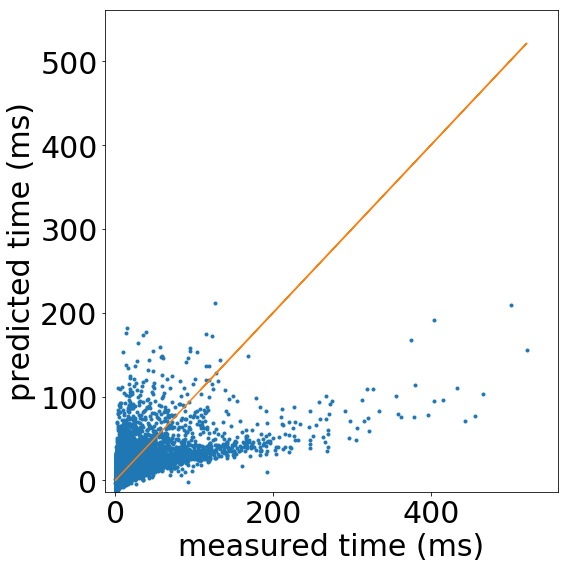

In [27]:
labels = [.2,.3,.4,.5,1]

RMS_vadiation_error=np.sqrt(np.mean((y_valid-lp)**2))
perc_error = np.mean(np.abs(y_valid-lp)/y_valid)*100
fig,ax = plt.subplots(1,1,figsize=[8,8])

ax.plot(y_valid,lp,'.')

ax.plot(y_valid,y_valid)

ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(plt.NullFormatter())
ax.yaxis.set_minor_formatter(plt.NullFormatter())


matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 

plt.xlabel('measured time (ms)',fontsize=30)
plt.ylabel('predicted time (ms)',fontsize=30)

#plt.axis('equal')
ax.set_xlim(-axlim*.025,axlim*1.025)
ax.set_ylim(-axlim*.025,axlim*1.025)

# ax.xaxis.set_ticks([0,25,50,75,100,125])

plt.tight_layout()


# if useData == 'Conv':
#     plt.savefig('figures/Validation_%s_conv_linearreg.png' %model_name, dpi=300)
# elif useData == 'Dense':
#     plt.savefig('figures/Validation_%s_fc_linearreg.png' %model_name, dpi=300)

plt.show()

In [28]:
RMS_vadiation_error

27.668052627635994

In [29]:
perc_error

399.8930186624436

#### Out Results

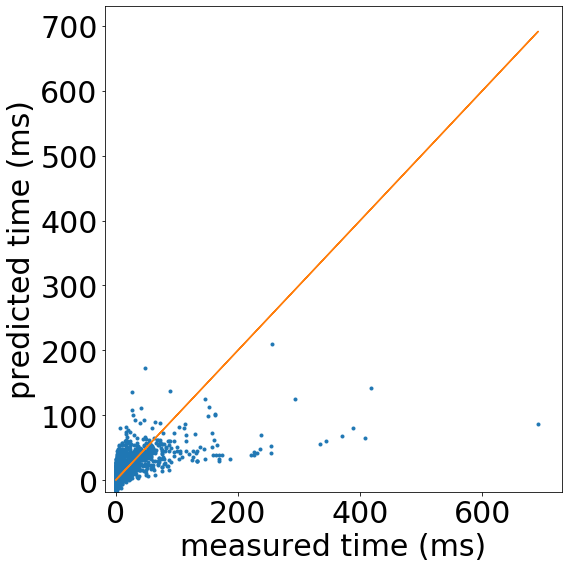

In [90]:
labels = [.2,.3,.4,.5,1]

RMS_vadiation_error=np.sqrt(np.mean((y_valid-lp)**2))
perc_error = np.mean(np.abs(y_valid-lp)/y_valid)*100
fig,ax = plt.subplots(1,1,figsize=[8,8])

ax.plot(y_valid,lp,'.')

ax.plot(y_valid,y_valid)

ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(plt.NullFormatter())
ax.yaxis.set_minor_formatter(plt.NullFormatter())


matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 

plt.xlabel('measured time (ms)',fontsize=30)
plt.ylabel('predicted time (ms)',fontsize=30)

#plt.axis('equal')
ax.set_xlim(-axlim*.025,axlim*1.025)
ax.set_ylim(-axlim*.025,axlim*1.025)

# ax.xaxis.set_ticks([0,25,50,75,100,125])

plt.tight_layout()


# if useData == 'Conv':
#     plt.savefig('figures/Validation_%s_conv_linearreg.png' %model_name, dpi=300)
# elif useData == 'Dense':
#     plt.savefig('figures/Validation_%s_fc_linearreg.png' %model_name, dpi=300)

plt.show()

In [91]:
RMS_vadiation_error

36.91193461958649

In [92]:
perc_error

379.6874366923085